In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os

In [4]:
os.getenv("LANGCHAIN_PROJECT")
os.getenv("LANGCHAIN_API_KEY")
## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]="true"

In [3]:

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [5]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
#llm = ChatOpenAI(model="gpt-4o")
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [6]:
llm.invoke("hi hello how are you?")

AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.194720861, 'prompt_time': 0.000602802, 'queue_time': 0.056507718, 'total_time': 0.195323663}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a39781d-bb49-43b1-9de5-03eee41bf4bf-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})

In [7]:
print(llm.invoke("What is the capital of France?").content)

<think>

</think>

The capital of France is Paris.


In [8]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [9]:
search_tool.invoke("What is the capital of France?")

[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

In [10]:
from langgraph.types import Command

In [12]:
from langchain_experimental.utilities import PythonREPL

In [13]:
repl=PythonREPL()

In [14]:
code = """
x = 5
y = x * 2
print(y)
"""

In [15]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [16]:
from typing import Annotated
from langchain_core.tools import tool
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    

In [17]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x0000025255B00900>)

In [18]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


till now have 2 tools:
- search_tool: for web searching
- python_repl_tool : for running python code

list of members


In [19]:
members=["researcher","coder"]


In [20]:
members

['researcher', 'coder']

In [21]:
options = members+["FINISH"]

In [22]:
options

['researcher', 'coder', 'FINISH']

In [23]:
from typing import Literal
from typing_extensions import TypedDict

In [24]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

In [25]:
from langgraph.graph import MessagesState,StateGraph,START, END

In [26]:
class State(MessagesState):
    next:str

In [27]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [28]:
system_prompt

'"\nYou are a supervisor, tasked with managing a conversation between the following workers: [\'researcher\', \'coder\']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n'

In [29]:
print('"\nYou are a supervisor, tasked with managing a conversation between the following workers: [\'researcher\', \'coder\']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n')

"
You are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.



creating Agents

In [30]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
        
    return Command(goto=goto, update={"next":goto})

In [39]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

In [32]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
    

In [33]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    

this is my orchestration flow with langgraph

In [34]:
graph=StateGraph(State)
graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", research_agent)
graph.add_node("coder", coder_agent)

graph.add_edge(START, "supervisor")

In [35]:
app=graph.compile()

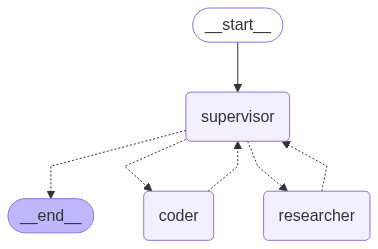

In [36]:
app

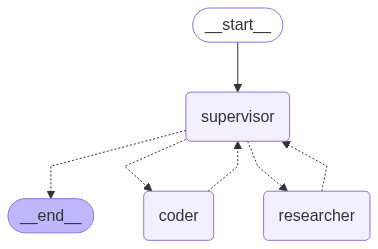

In [37]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
for s in app.stream({"messages": [("user", "What's the square root of 42? and how to write a python code")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:88b0f12c-fc5e-dffb-bc6c-741605445241',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.4807. \n\nHere\'s a Python code snippet to calculate and print the square root of 42:\n\n```python\nimport math\n\nsquare_root = math.sqrt(42)\nprint("The square root of 42 is:", square_root)\n```\n\nThis code imports the math module, calculates the square root using `math.sqrt()`, and then prints the result.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 360, 'prompt_tokens': 186, 'total_tokens': 546, 'completion_time': 1.336115752, 'prompt_time': 0.013398231, 'queue_time': 0.060294402, 'total_time': 1.349513983}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd3e4941-5eb8-4438-a84a-d82

KeyboardInterrupt: 